In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import keras
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Dense,LSTM,Activation,Embedding,Bidirectional,InputLayer
import re
import nltk
from nltk.corpus import stopwords,wordnet
nltk.download('stopwords')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import scipy.stats as stats
import cufflinks as cf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tashatanarugsachock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.DataFrame(pd.read_excel('Restaurant Data.xlsx'))
df.head(5)

,restaurant,type,cuisine,taste,beverage,service,cost,location,buffet,opinion,sentiment,satisfied
0,Sookdal,savory,korean,4.0,0.0,0.0,400.0,1.0,0.0,Sound pretty expensive because it is not buffet,negative,1.0
1,Sushiro,savory,japanese,4.0,0.0,0.0,800.0,2.0,0.0,The price is actually good for single plate bu...,negative,0.0
2,Momo Paradise,savory,japanese,4.0,0.0,0.0,659.0,1.8,1.0,"Delicious place to eat buffet with friends,pre...",positive,1.0
3,Rengaya,savory,japanese,5.0,0.0,1.0,1250.0,3.5,0.0,Super good meat that melts in your mouth,positive,1.0
4,Bar B Q Plaza,savory,thai,3.0,0.0,1.0,400.0,2.0,0.0,Pretty expensive and not so many choice to cho...,negative,0.0


Exploring Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   restaurant  116 non-null    object 
 1   type        116 non-null    object 
 2   cuisine     116 non-null    object 
 3   taste       116 non-null    float64
 4   beverage    116 non-null    float64
 5   service     116 non-null    float64
 6   cost        116 non-null    float64
 7   location    116 non-null    float64
 8   buffet      116 non-null    float64
 9   opinion     116 non-null    object 
 10  sentiment   116 non-null    object 
 11  satisfied   116 non-null    float64
dtypes: float64(7), object(5)
memory usage: 11.0+ KB


# Which cuisine is the most satisfied?

ranking cuisine based on number of restaurant visited and categorize them by satisfaction and country

In [7]:
cuisine_list = df['cuisine'].str.split(',').tolist()

In [8]:
mlb = MultiLabelBinarizer()
cuisine_df = pd.DataFrame(mlb.fit_transform(cuisine_list), columns = mlb.classes_)
cuisine_df['satisfied'] = df['satisfied'].astype(int)
cuisine_df

,chinese,french,hongkongese,indian,italian,japanese,korean,taiwanese,thai,usa,satisfied
0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
111,0,0,0,0,0,0,0,0,0,1,1
112,0,0,0,0,0,1,0,0,0,0,0
113,0,0,0,0,1,0,0,0,1,0,1
114,0,0,0,0,0,0,0,0,0,1,1


In [9]:
mlb.classes_

array(['chinese', 'french', 'hongkongese', 'indian', 'italian',
       'japanese', 'korean', 'taiwanese', 'thai', 'usa'], dtype=object)

In [10]:
cuisine_cols = [x for x in cuisine_df.columns if x != 'satisfied']

cuisine_rank = pd.DataFrame(columns=['cuisine','satisfied','unsatisfied'])
cuisine_rank['cuisine'] = cuisine_cols
for index, cuisine in enumerate(cuisine_rank['cuisine']):
    cuisine_rank.loc[index, 'satisfied'] = cuisine_df[(cuisine_df[cuisine] == 1) & (cuisine_df['satisfied'] == 1)].shape[0]
    cuisine_rank.loc[index, 'unsatisfied'] =  cuisine_df[(cuisine_df[cuisine] == 1) & (cuisine_df['satisfied'] == 0)].shape[0]
cuisine_rank

,cuisine,satisfied,unsatisfied
0,chinese,4,4
1,french,2,2
2,hongkongese,1,0
3,indian,2,1
4,italian,5,3
5,japanese,17,20
6,korean,5,13
7,taiwanese,2,2
8,thai,12,8
9,usa,14,13


In [11]:
# analyze which cuisine is the most satisfied and unsatisfied based on number of restaurant visited

cuisine_rank.insert(column = 'percentage', value = 0, loc = 3)
for cuisine in enumerate(cuisine_rank['cuisine']):
    cuisine_rank['percentage'] = (cuisine_rank['satisfied']/(cuisine_rank['satisfied'] + cuisine_rank['unsatisfied']))*100
    cuisine_rank['total'] = cuisine_rank['satisfied'] + cuisine_rank['unsatisfied']
cuisine_rank

,cuisine,satisfied,unsatisfied,percentage,total
0,chinese,4,4,50.0,8
1,french,2,2,50.0,4
2,hongkongese,1,0,100.0,1
3,indian,2,1,66.666667,3
4,italian,5,3,62.5,8
5,japanese,17,20,45.945946,37
6,korean,5,13,27.777778,18
7,taiwanese,2,2,50.0,4
8,thai,12,8,60.0,20
9,usa,14,13,51.851852,27


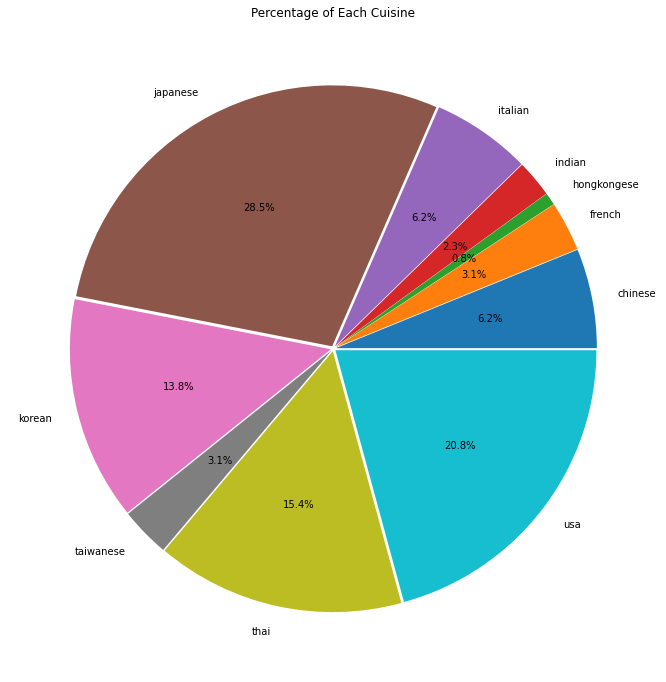

In [12]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)

explode = [0.01]*10
# Creating plot
fig, ax= plt.subplots(figsize =(12, 12))
plt.pie(cuisine_rank['total'], labels = cuisine_rank['cuisine'], explode = explode, autopct = lambda pct: func(pct, cuisine_rank['total']))
ax.set_title("Percentage of Each Cuisine")

# show plot
plt.show()

In [13]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(cuisine_rank.columns),
                fill_color='#0C84A1',
                line_color = '#0C84A1',
                align='center',
                font=dict(color='white', size=12)),
    cells=dict(values=[cuisine_rank.cuisine, cuisine_rank.satisfied, cuisine_rank.unsatisfied, cuisine_rank.percentage, cuisine_rank.total],
               fill_color='white',
               line_color = '#0C84A1',
               align='left'), domain=dict(x=[0,0.5]))
])

fig.show()

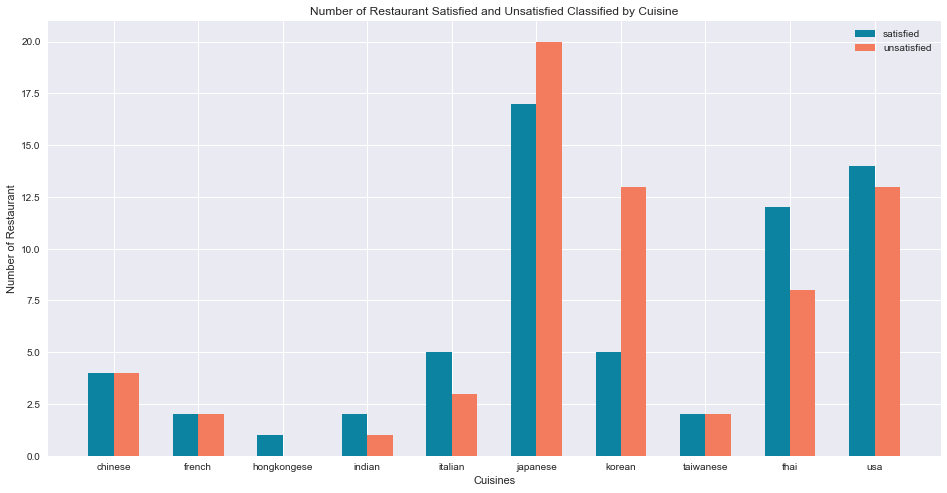

In [14]:
cuisine = cuisine_rank['cuisine'].unique()
satisfied = cuisine_rank['satisfied']
unsatisfied = cuisine_rank['unsatisfied']

x_axis = np.arange(len(cuisine))

plt.figure(figsize = (16,8))
plt.style.use('seaborn')

plt.bar(x_axis - 0.15, satisfied, 0.3, color = '#0C84A1', label = 'satisfied')
plt.bar(x_axis + 0.15, unsatisfied, 0.3, color = '#F37B5E', label = 'unsatisfied')

plt.xticks(x_axis, cuisine)
plt.xlabel("Cuisines")
plt.ylabel("Number of Restaurant")
plt.title("Number of Restaurant Satisfied and Unsatisfied Classified by Cuisine") 
plt.legend()
plt.show()


In [15]:
cuisine_rank['code'] = ['CHN', 'FRA', 'HKG', 'IND', 'ITA', 'JPN', 'KOR', 'TWN', 'THA', 'USA']
cuisine_rank

,cuisine,satisfied,unsatisfied,percentage,total,code
0,chinese,4,4,50.0,8,CHN
1,french,2,2,50.0,4,FRA
2,hongkongese,1,0,100.0,1,HKG
3,indian,2,1,66.666667,3,IND
4,italian,5,3,62.5,8,ITA
5,japanese,17,20,45.945946,37,JPN
6,korean,5,13,27.777778,18,KOR
7,taiwanese,2,2,50.0,4,TWN
8,thai,12,8,60.0,20,THA
9,usa,14,13,51.851852,27,USA


<AxesSubplot:>

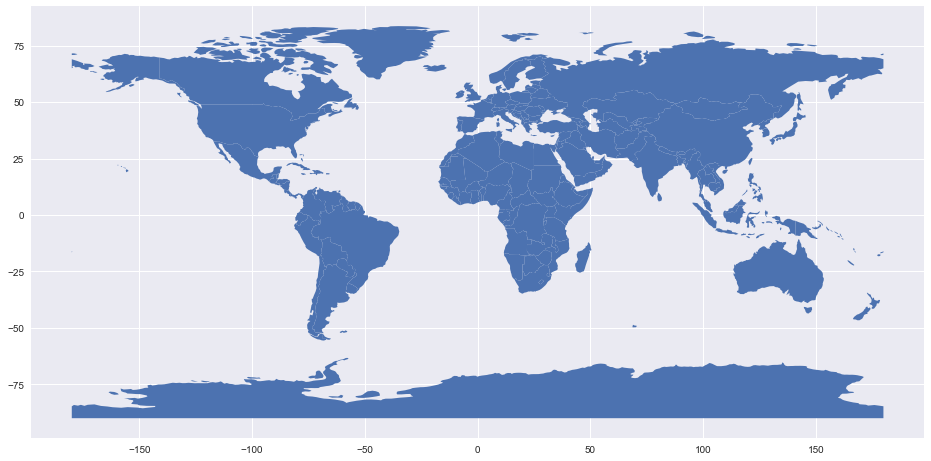

In [16]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(figsize = (16,8))

In [17]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [18]:
world.insert(column = 'cuisine', value = np.NaN, loc = 6)
world.insert(column = 'restaurants', value = np.NaN, loc = 7)
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,cuisine,restaurants
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",NaN,NaN
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",NaN,NaN


In [19]:
world.loc[world['iso_a3'] == 'CHN', 'cuisine'] = 'chinese'
world.loc[world['iso_a3'] == 'FRA', 'cuisine'] = 'french'
world.loc[world['iso_a3'] == 'HKG', 'cuisine'] = 'hongkongese'
world.loc[world['iso_a3'] == 'IND', 'cuisine'] = 'indian'
world.loc[world['iso_a3'] == 'ITA', 'cuisine'] = 'italian'
world.loc[world['iso_a3'] == 'JPN', 'cuisine'] = 'japanese'
world.loc[world['iso_a3'] == 'KOR', 'cuisine'] = 'korean'
world.loc[world['iso_a3'] == 'TWN', 'cuisine'] = 'taiwanese'
world.loc[world['iso_a3'] == 'THA', 'cuisine'] = 'thai'
world.loc[world['iso_a3'] == 'USA', 'cuisine'] = 'usa'
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,cuisine,restaurants
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",NaN,NaN
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",usa,NaN


In [20]:
world.loc[world['iso_a3'] == 'CHN', 'restaurants'] = 8
world.loc[world['iso_a3'] == 'FRA', 'restaurants'] = 4
world.loc[world['iso_a3'] == 'HKG', 'restaurants'] = 1
world.loc[world['iso_a3'] == 'IND', 'restaurants'] = 3
world.loc[world['iso_a3'] == 'ITA', 'restaurants'] = 8
world.loc[world['iso_a3'] == 'JPN', 'restaurants'] = 37
world.loc[world['iso_a3'] == 'KOR', 'restaurants'] = 18
world.loc[world['iso_a3'] == 'TWN', 'restaurants'] = 4
world.loc[world['iso_a3'] == 'THA', 'restaurants'] = 29
world.loc[world['iso_a3'] == 'USA', 'restaurants'] = 27
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,cuisine,restaurants
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",NaN,NaN
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",usa,27.0


Text(0.5, 1.0, 'Number of Restaurant in Each Cuisine')

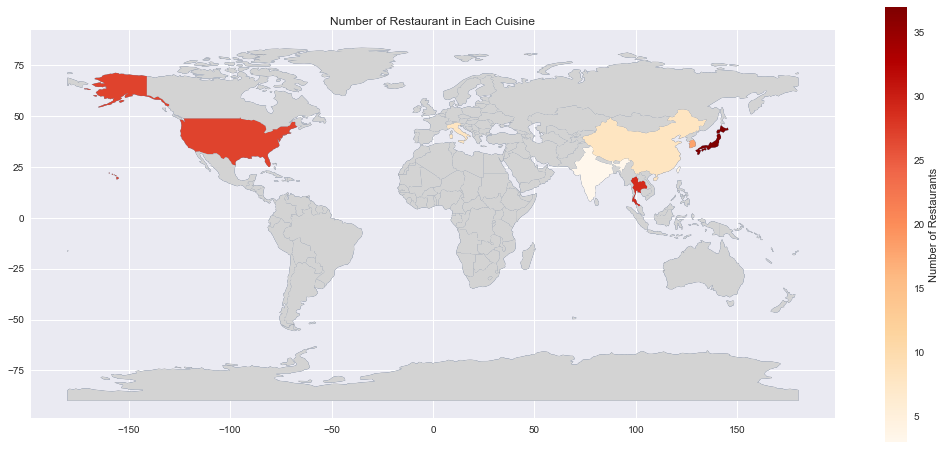

In [21]:
# use world map to visualize number of restaurant visited based on country

ax = world["geometry"].plot(figsize=(18,8), edgecolor = 'grey')
world.plot( column = "restaurants", ax = ax, cmap='OrRd', linewidth = 0,
                     legend = True, legend_kwds = {'label': 'Number of Restaurants'}, missing_kwds={'color': 'lightgrey'})
ax.set_title("Number of Restaurant in Each Cuisine")

# What price range is the most satisfied?
ranking price range based on number of restaurant visited

In [22]:
df['cost'].describe()

count     116.000000
mean      296.948276
std       252.007931
min        20.000000
25%       136.750000
50%       222.500000
75%       368.500000
max      1500.000000
Name: cost, dtype: float64

In [23]:
cost_df = pd.DataFrame(df['cost'])
cost_df['interval'] = pd.cut(df['cost'], bins = 5)
cost_df['satisfied'] = df['satisfied'].astype(int)
cost_df

,cost,interval,satisfied
0,400.0,"(316.0, 612.0]",1
1,800.0,"(612.0, 908.0]",0
2,659.0,"(612.0, 908.0]",1
3,1250.0,"(1204.0, 1500.0]",1
4,400.0,"(316.0, 612.0]",0
...,...,...,...
111,200.0,"(18.52, 316.0]",1
112,200.0,"(18.52, 316.0]",0
113,330.0,"(316.0, 612.0]",1
114,150.0,"(18.52, 316.0]",1


In [24]:
cost_rank = pd.DataFrame(columns=['cost','satisfied','unsatisfied'])
cost_rank['cost'] = pd.cut(df['cost'], bins = 5).unique().sort_values()
for index, interval in enumerate(cost_rank['cost'] ):
    cost_rank.loc[index, 'satisfied'] = cost_df[(cost_df['interval'] == interval) & (cost_df['satisfied'] == 1)].shape[0]
    cost_rank.loc[index, 'unsatisfied'] =  cost_df[(cost_df['interval'] == interval) & (cost_df['satisfied'] == 0)].shape[0]
cost_rank

,cost,satisfied,unsatisfied
0,"(18.52, 316.0]",37,43
1,"(316.0, 612.0]",11,13
2,"(612.0, 908.0]",4,4
3,"(908.0, 1204.0]",1,1
4,"(1204.0, 1500.0]",1,1


In [25]:
# analyze which cost range is the most satisfied and unsatisfied based on number of restaurant visited

cost_rank['percentage'] = ((cost_rank['satisfied'] + cost_rank['unsatisfied'])/116)*100
cost_rank

,cost,satisfied,unsatisfied,percentage
0,"(18.52, 316.0]",37,43,68.965517
1,"(316.0, 612.0]",11,13,20.689655
2,"(612.0, 908.0]",4,4,6.896552
3,"(908.0, 1204.0]",1,1,1.724138
4,"(1204.0, 1500.0]",1,1,1.724138


(array([79., 25.,  8.,  2.,  2.]),
 array([  20.,  316.,  612.,  908., 1204., 1500.]),
 <BarContainer object of 5 artists>)

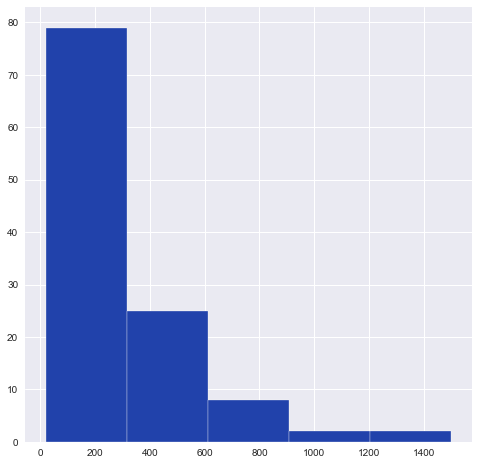

In [26]:
plt.figure(figsize = (8,8))
plt.hist(cost_df['cost'], bins = 5, edgecolor = 'white', color = '#2142AB')


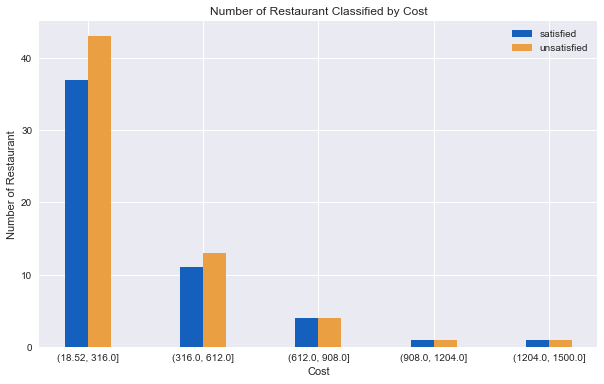

In [27]:
cost = cost_rank['cost'].unique()
satisfied = cost_rank['satisfied']
unsatisfied = cost_rank['unsatisfied']

x_axis = np.arange(len(cost))

plt.figure(figsize = (10,6))

plt.bar(x_axis - 0.1, satisfied, 0.2, color = '#1560BD', label = 'satisfied')
plt.bar(x_axis + 0.1, unsatisfied, 0.2, color = '#EA9F42', label = 'unsatisfied')

plt.xticks(x_axis, cost)
plt.xlabel("Cost")
plt.ylabel("Number of Restaurant")
plt.title("Number of Restaurant Classified by Cost") 
plt.legend()
plt.show()


# What is the keyword for positive and negative opinion?
find the keywords from opinion that make the sentiment positive or negative based on how frequent the word is used

In [28]:
opinion_key_df = pd.DataFrame()
opinion_key_df['opinion'] = df['opinion']
opinion_key_df['sentiment'] = df['sentiment']
opinion_key_df

,opinion,sentiment
0,Sound pretty expensive because it is not buffet,negative
1,The price is actually good for single plate bu...,negative
2,"Delicious place to eat buffet with friends,pre...",positive
3,Super good meat that melts in your mouth,positive
4,Pretty expensive and not so many choice to cho...,negative
...,...,...
111,Nice dessert place to eat and to treat a frien...,positive
112,Nice beef and onion but too much rice in each ...,neutral
113,Nice place to have a quick meal because it is ...,positive
114,Nice place to have a quick meal because it is ...,positive


In [29]:
is_positive = opinion_key_df['sentiment'] == 'positive'
opinion_positive = opinion_key_df[is_positive]
opinion_positive.head()


,opinion,sentiment
2,"Delicious place to eat buffet with friends,pre...",positive
3,Super good meat that melts in your mouth,positive
5,Great quality and healthy food with salmon sas...,positive
11,Premium international buffet with great food v...,positive
12,"Good taste and pretty cheap,better than Bonchon",positive


In [30]:
is_negative = opinion_key_df['sentiment'] == 'negative'
opinion_negative = opinion_key_df[is_negative]
opinion_negative.head()

,opinion,sentiment
0,Sound pretty expensive because it is not buffet,negative
1,The price is actually good for single plate bu...,negative
4,Pretty expensive and not so many choice to cho...,negative
6,Very expensive and the food took a very long t...,negative
8,Have to wait for the food for a very long time...,negative


In [31]:
positive_key = " ".join(np.asarray(opinion_positive['opinion']).flatten())

In [32]:
negative_key = " ".join(np.asarray(opinion_negative['opinion']).flatten())

In [33]:
# add neutral meaning words to the stopword list in order to exclude from the analysis

stw = stopwords.words('english')
stw.extend(['food', 'choice', 'place'])

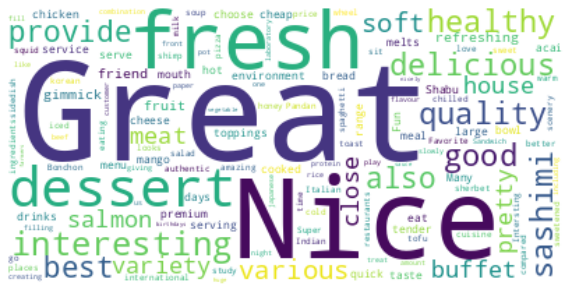

In [34]:
# use wordcloud to visualize the frequently used words in positive opinion

positive_wordcloud = WordCloud(max_font_size = 100, max_words = 150, background_color = "white", stopwords = stw).generate(positive_key)
positive_wordcloud.to_file("positive_wordcloud.png")

plt.figure(figsize = (10,8))
plt.imshow(positive_wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

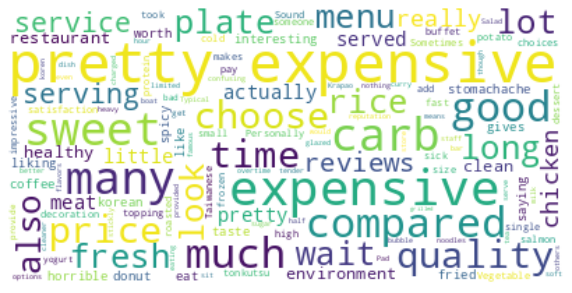

In [35]:
# use wordcloud to visualize the frequently used words in negative opinion

negative_wordcloud = WordCloud(max_font_size = 100, max_words = 150, background_color = "white", stopwords = stw).generate(negative_key)
negative_wordcloud.to_file("negative_wordcloud.png")

plt.figure(figsize = (10,8))
plt.imshow(negative_wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

masking wordcloud

In [36]:
positive_mask = np.array(Image.open('positive_mask.png'))

In [37]:
transformed_positive_mask = np.ndarray((positive_mask.shape[0],positive_mask.shape[1]), np.int32)

for i in range(len(positive_mask[0])):
    for j in range(len(positive_mask[0])):
        if transformed_positive_mask[i,j] == 0:
            transformed_positive_mask[i,j] = 255
transformed_positive_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

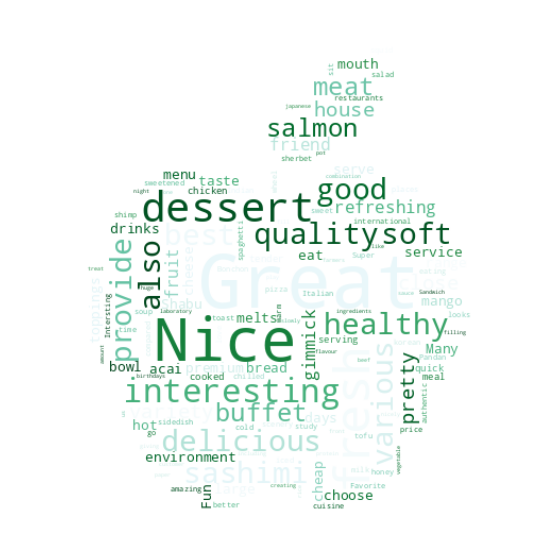

In [38]:
transformed_positive_wordcloud = WordCloud(max_font_size = 70, max_words = 1000,background_color = "white", colormap = 'BuGn',contour_width = 0, contour_color = '#2EA18C', stopwords = stw, mask = transformed_positive_mask)

transformed_positive_wordcloud.generate(positive_key)

transformed_positive_wordcloud.to_file("transformed_positive_wordcloud.png")

plt.figure(figsize=(20,10))
plt.imshow(transformed_positive_wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [39]:
negative_mask = np.array(Image.open('negative_mask.png'))

In [40]:
transformed_negative_mask = np.ndarray((negative_mask.shape[0],negative_mask.shape[1]), np.int32)

for i in range(len(negative_mask[0])):
    for j in range(len(negative_mask[0])):
        if transformed_negative_mask[i,j] == 0:
            transformed_negative_mask[i,j] = 255
transformed_negative_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

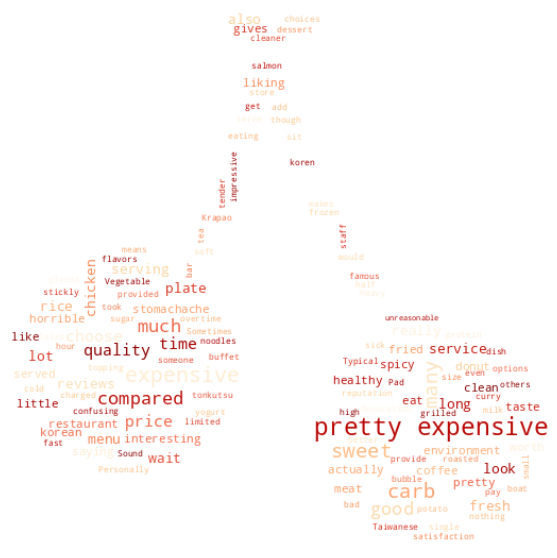

In [41]:
transformed_negative_wordcloud = WordCloud(max_font_size = 80, max_words = 1000, background_color = "white", colormap = 'OrRd',contour_width = 0, contour_color = '#2EA18C', stopwords = stw, mask = transformed_negative_mask)

transformed_negative_wordcloud.generate(negative_key)

transformed_negative_wordcloud.to_file("transformed_negative_wordcloud.png")

plt.figure(figsize=(20,10))
plt.imshow(transformed_negative_wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Sentiment Prediction
predicting sentiment – positive, negative, or neutral – from the input opinion using natural language processing (2-layer-LSTM model)

In [42]:
opinion_df = pd.DataFrame(df['opinion'])
opinion_df['sentiment'] = df['sentiment']
opinion_df

,opinion,sentiment
0,Sound pretty expensive because it is not buffet,negative
1,The price is actually good for single plate bu...,negative
2,"Delicious place to eat buffet with friends,pre...",positive
3,Super good meat that melts in your mouth,positive
4,Pretty expensive and not so many choice to cho...,negative
...,...,...
111,Nice dessert place to eat and to treat a frien...,positive
112,Nice beef and onion but too much rice in each ...,neutral
113,Nice place to have a quick meal because it is ...,positive
114,Nice place to have a quick meal because it is ...,positive


In [43]:
# change from string value to int in order to create a sequential model

opinion_df['sentiment'].replace({'negative' : 0, 'neutral' : 1, 'positive' : 2}, inplace = True)
opinion_df

,opinion,sentiment
0,Sound pretty expensive because it is not buffet,0
1,The price is actually good for single plate bu...,0
2,"Delicious place to eat buffet with friends,pre...",2
3,Super good meat that melts in your mouth,2
4,Pretty expensive and not so many choice to cho...,0
...,...,...
111,Nice dessert place to eat and to treat a frien...,2
112,Nice beef and onion but too much rice in each ...,1
113,Nice place to have a quick meal because it is ...,2
114,Nice place to have a quick meal because it is ...,2


In [44]:
vocab_size = 20000  # only consider the top 20k words
maxlen = 200 # only first 200 words of each record

In [45]:
def get_wordnet_pos(word):
    "Map POS tag to first character lemmatize() accepts"
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [46]:
def text_cleaning(text):
    stop_word = set(stopwords.words('english'))
    if text:
        text = ' '.join(text.split('.'))
        # \ Signals a special sequence (can also be used to escape special characters)
        text = re.sub('\/',' ',text)
        # "r" in the beginning is making sure that the string is being treated as a "raw string"
        text = re.sub(r'\\',' ',text)
        # \S the string DOES NOT contain a white space character
        text = re.sub(r'((http)\S+)',' ',text)
        # \s the string contains a white space character
        # [^A-Za-z] a match for any character EXCEPT any character alphabetically between a and z, lower case OR upper case
        text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
        # \W where the string DOES NOT contain any word characters (characters from a to Z, digits from 0-9, and the underscore _ character)
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
        text = [word for word in text.split() if word not in stop_word]
        text=[nltk.WordNetLemmatizer().lemmatize(word,get_wordnet_pos(word)) for word in text]
        return text
    return []

In [47]:
opinion_df['opinion'] = opinion_df['opinion'].apply(lambda x: ' '.join(text_cleaning(x)))
opinion = opinion_df['opinion'].tolist()
encoded_phrases = [one_hot(d, vocab_size) for d in opinion] # encode words into numbers
opinion_df['opinion'] = encoded_phrases
x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(opinion_df['opinion'], opinion_df['sentiment'], test_size = 0.3, random_state = 123)

In [48]:
opinion

['sound pretty expensive buffet',
 'price actually good single plate add pretty expensive little plate',
 'delicious place eat buffet friend premium meat nice soup great mango sherbet',
 'super good meat melt mouth',
 'pretty expensive many choice choose menu',
 'great quality healthy food salmon sashimi',
 'expensive food take long time serve',
 'interest menu net price high compated price menu',
 'wait food long time lot carb',
 'many choice meat lot carb',
 'personally tonkutsu pay much',
 'premium international buffet great food variety quality great service',
 'good taste pretty cheap well bonchon',
 'fry chicken okay',
 'great quality food fresh salmon sashimi',
 'great quality food close house',
 'much rice little top',
 'low price food acceptable taste',
 'carb pretty high price compare satisfaction',
 'carb healthy',
 'healthy food many choice choose',
 'provide healthy choice actually interest',
 'really healthy choice taste good provide interest menu',
 'sometimes food quali

In [49]:
y_train_text.unique()

array([0, 2, 1])

In [50]:
x_train_text.head()

72                                 [264, 10462, 10897]
113            [13252, 16255, 4505, 6765, 14019, 1694]
21                    [7963, 15363, 8231, 3718, 12393]
54            [9003, 15363, 19249, 8231, 17391, 11842]
77     [13252, 18522, 11569, 12461, 1132, 10358, 1041]
Name: opinion, dtype: object

In [51]:
x_train_text = keras.preprocessing.sequence.pad_sequences(x_train_text, maxlen = maxlen)
x_test_text = keras.preprocessing.sequence.pad_sequences(x_test_text, maxlen = maxlen)

In [52]:
x_train_text

array([[    0,     0,     0, ...,   264, 10462, 10897],
       [    0,     0,     0, ...,  6765, 14019,  1694],
       [    0,     0,     0, ...,  8231,  3718, 12393],
       ...,
       [    0,     0,     0, ..., 13222, 19148, 12393],
       [    0,     0,     0, ..., 13252, 14266,  9787],
       [    0,     0,     0, ...,     0,  4445,  1396]], dtype=int32)

In [53]:
y_train_text

72     0
113    2
21     1
54     2
77     2
      ..
102    2
98     0
92     2
66     1
109    0
Name: sentiment, Length: 81, dtype: int64

In [54]:
# 2-layer-LSTM model is used because of its advatage in memorizing text patterns and propagating the input in both dierections – forwards and backwards making the model more accurate

textmodel = Sequential()
# embed each integer in a 128-dimensional vector to reduce dimensions
textmodel.add(Embedding(input_dim = vocab_size, output_dim = 128, input_length = maxlen))
# add 2 bidirectional LSTMs
textmodel.add(Bidirectional(LSTM(32, return_sequences = True)))
textmodel.add(Bidirectional(LSTM(32)))
textmodel.add(keras.layers.Dropout(0.5))
# add a classifier with dense 3 
textmodel.add(Dense(3, activation = "sigmoid"))
# model = keras.Model(inputs, outputs)
textmodel.summary()

2022-05-05 21:38:41.571370: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 64)          41216     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 2,626,243
Trainable params: 2,626,243
Non-

In [55]:
# train and predict LSTM model and see accuracy

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

textmodel.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
textmodel.fit(x_train_text, y_train_text, batch_size = 18, epochs = 20, callbacks=[es_callback], validation_data=(x_test_text, y_test_text))

Epoch 1/20
5/5 [==============================] - 8s 494ms/step - loss: 1.0986 - accuracy: 0.3704 - val_loss: 1.1050 - val_accuracy: 0.2857
Epoch 2/20
5/5 [==============================] - 1s 173ms/step - loss: 1.0907 - accuracy: 0.3827 - val_loss: 1.0984 - val_accuracy: 0.2857
Epoch 3/20
5/5 [==============================] - 1s 147ms/step - loss: 1.0904 - accuracy: 0.4568 - val_loss: 1.0993 - val_accuracy: 0.3429
Epoch 4/20
5/5 [==============================] - 1s 135ms/step - loss: 1.0698 - accuracy: 0.5309 - val_loss: 1.0948 - val_accuracy: 0.4286
Epoch 5/20
5/5 [==============================] - 1s 137ms/step - loss: 1.0532 - accuracy: 0.5679 - val_loss: 1.0832 - val_accuracy: 0.5429
Epoch 6/20
5/5 [==============================] - 1s 135ms/step - loss: 1.0291 - accuracy: 0.5679 - val_loss: 1.0826 - val_accuracy: 0.4000
Epoch 7/20
5/5 [==============================] - 1s 134ms/step - loss: 0.9879 - accuracy: 0.6914 - val_loss: 1.0555 - val_accuracy: 0.5714
Epoch 8/20
5/5 [====

In [56]:
# predict y as the column that projects the most value – negative, neutral, positive

y_pred =  textmodel.predict(x_test_text)
y_pred

array([[0.90867394, 0.6077886 , 0.26461604],
       [0.76902807, 0.7635674 , 0.23964056],
       [0.27275735, 0.71178424, 0.44553804],
       [0.91855323, 0.5896702 , 0.2692377 ],
       [0.3650971 , 0.7785542 , 0.33383757],
       [0.53356975, 0.82668626, 0.2397339 ],
       [0.83830523, 0.7080353 , 0.24584043],
       [0.6363492 , 0.81989396, 0.22568151],
       [0.83733505, 0.6942994 , 0.2647524 ],
       [0.5223153 , 0.8098429 , 0.2707561 ],
       [0.79552877, 0.74156374, 0.24429911],
       [0.9160242 , 0.5986607 , 0.264911  ],
       [0.1681129 , 0.28624505, 0.86333275],
       [0.86742604, 0.673027  , 0.25743848],
       [0.8451668 , 0.7142229 , 0.23674941],
       [0.2078458 , 0.2915808 , 0.8657432 ],
       [0.8558216 , 0.693689  , 0.24940345],
       [0.23521137, 0.63163495, 0.5635575 ],
       [0.90812767, 0.60561556, 0.26603484],
       [0.4195732 , 0.81385094, 0.27092713],
       [0.17266971, 0.28221184, 0.8658468 ],
       [0.20126206, 0.54722095, 0.66348433],
       [0.

In [57]:
y_pred_max = np.argmax(y_pred, axis = 1, keepdims = True)
y_pred_max

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [2],
       [0],
       [0],
       [2],
       [0],
       [1],
       [0],
       [1],
       [2],
       [2],
       [0],
       [2],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [2],
       [0],
       [2],
       [0],
       [0]])

<AxesSubplot:>

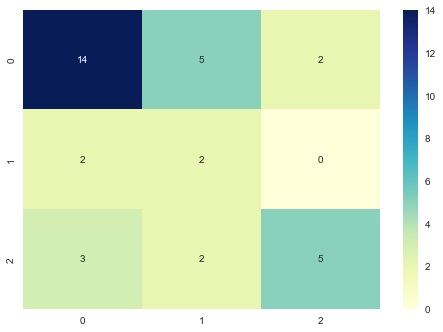

In [58]:
# use heatmap to show the accuracy of the prediction

cf_matrix = sklearn.metrics.confusion_matrix(y_test_text, y_pred_max, labels = None, sample_weight = None, normalize = None)
sns.heatmap(cf_matrix, annot = True, cmap = 'YlGnBu')

# Satisfaction Prediction
predicting satisfaction using logistic regression using input variables : restaurant, type, taste, beverage, service, cost, location, buffet, opinion, sentiment

Preprocessing Data

In [59]:
df.head()

,restaurant,type,cuisine,taste,beverage,service,cost,location,buffet,opinion,sentiment,satisfied
0,Sookdal,savory,korean,4.0,0.0,0.0,400.0,1.0,0.0,Sound pretty expensive because it is not buffet,negative,1.0
1,Sushiro,savory,japanese,4.0,0.0,0.0,800.0,2.0,0.0,The price is actually good for single plate bu...,negative,0.0
2,Momo Paradise,savory,japanese,4.0,0.0,0.0,659.0,1.8,1.0,"Delicious place to eat buffet with friends,pre...",positive,1.0
3,Rengaya,savory,japanese,5.0,0.0,1.0,1250.0,3.5,0.0,Super good meat that melts in your mouth,positive,1.0
4,Bar B Q Plaza,savory,thai,3.0,0.0,1.0,400.0,2.0,0.0,Pretty expensive and not so many choice to cho...,negative,0.0


In [60]:
type_array = np.asarray(df['type'])
type_array.flatten()
type_array = np.reshape(type_array, (116,1))
type_array

array([['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['sweet'],
       ['sweet'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['savory'],
       ['sweet'],
       ['savory'],
       ['savory

In [61]:
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(type_array)
enc.categories_

[array(['drinks', 'savory', 'sweet'], dtype=object)]

In [62]:
type_df = pd.DataFrame(enc.transform(type_array).toarray(), columns = ['drinks', 'savory', 'sweet'])
type_df

,drinks,savory,sweet
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
111,0.0,0.0,1.0
112,0.0,1.0,0.0
113,0.0,1.0,0.0
114,0.0,1.0,0.0


In [63]:
index = 2
for column in type_df.columns:
    df.insert(loc = index, column = column, value = type_df[column])
    index + 1
df

,restaurant,type,sweet,savory,drinks,cuisine,taste,beverage,service,cost,location,buffet,opinion,sentiment,satisfied
0,Sookdal,savory,0.0,1.0,0.0,korean,4.0,0.0,0.0,400.0,1.00,0.0,Sound pretty expensive because it is not buffet,negative,1.0
1,Sushiro,savory,0.0,1.0,0.0,japanese,4.0,0.0,0.0,800.0,2.00,0.0,The price is actually good for single plate bu...,negative,0.0
2,Momo Paradise,savory,0.0,1.0,0.0,japanese,4.0,0.0,0.0,659.0,1.80,1.0,"Delicious place to eat buffet with friends,pre...",positive,1.0
3,Rengaya,savory,0.0,1.0,0.0,japanese,5.0,0.0,1.0,1250.0,3.50,0.0,Super good meat that melts in your mouth,positive,1.0
4,Bar B Q Plaza,savory,0.0,1.0,0.0,thai,3.0,0.0,1.0,400.0,2.00,0.0,Pretty expensive and not so many choice to cho...,negative,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Chikalicious,sweet,1.0,0.0,0.0,usa,3.0,1.0,0.0,200.0,3.80,0.0,Nice dessert place to eat and to treat a frien...,positive,1.0
112,Yoshinoya,savory,0.0,1.0,0.0,japanese,3.0,0.0,0.0,200.0,2.40,0.0,Nice beef and onion but too much rice in each ...,neutral,0.0
113,B Story,savory,0.0,1.0,0.0,"thai,italian",3.0,1.0,-1.0,330.0,0.75,0.0,Nice place to have a quick meal because it is ...,positive,1.0
114,Hungry Nerd,savory,0.0,1.0,0.0,usa,4.0,0.0,0.0,150.0,0.70,0.0,Nice place to have a quick meal because it is ...,positive,1.0


In [64]:
cuisine_df.drop('satisfied', axis = 1, inplace = True)

In [65]:
index = 6
for column in cuisine_df.columns:
    df.insert(loc = index, column = column, value = cuisine_df[column].astype(float))
    index + 1
df

,restaurant,type,sweet,savory,drinks,cuisine,usa,thai,taiwanese,korean,...,chinese,taste,beverage,service,cost,location,buffet,opinion,sentiment,satisfied
0,Sookdal,savory,0.0,1.0,0.0,korean,0.0,0.0,0.0,1.0,...,0.0,4.0,0.0,0.0,400.0,1.00,0.0,Sound pretty expensive because it is not buffet,negative,1.0
1,Sushiro,savory,0.0,1.0,0.0,japanese,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,800.0,2.00,0.0,The price is actually good for single plate bu...,negative,0.0
2,Momo Paradise,savory,0.0,1.0,0.0,japanese,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,659.0,1.80,1.0,"Delicious place to eat buffet with friends,pre...",positive,1.0
3,Rengaya,savory,0.0,1.0,0.0,japanese,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,1.0,1250.0,3.50,0.0,Super good meat that melts in your mouth,positive,1.0
4,Bar B Q Plaza,savory,0.0,1.0,0.0,thai,0.0,1.0,0.0,0.0,...,0.0,3.0,0.0,1.0,400.0,2.00,0.0,Pretty expensive and not so many choice to cho...,negative,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Chikalicious,sweet,1.0,0.0,0.0,usa,1.0,0.0,0.0,0.0,...,0.0,3.0,1.0,0.0,200.0,3.80,0.0,Nice dessert place to eat and to treat a frien...,positive,1.0
112,Yoshinoya,savory,0.0,1.0,0.0,japanese,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,200.0,2.40,0.0,Nice beef and onion but too much rice in each ...,neutral,0.0
113,B Story,savory,0.0,1.0,0.0,"thai,italian",0.0,1.0,0.0,0.0,...,0.0,3.0,1.0,-1.0,330.0,0.75,0.0,Nice place to have a quick meal because it is ...,positive,1.0
114,Hungry Nerd,savory,0.0,1.0,0.0,usa,1.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,150.0,0.70,0.0,Nice place to have a quick meal because it is ...,positive,1.0


In [66]:
sentiment_df = pd.DataFrame()
sentiment_df['sentiment_value'] = df['sentiment'].replace({'negative' : -1, 'neutral' : 0, 'positive' : 1})
sentiment_df

,sentiment_value
0,-1
1,-1
2,1
3,1
4,-1
...,...
111,1
112,0
113,1
114,1


In [67]:
# change all categorial data to numberical data using OneHotEncoder (type) and MultiLabelBinarizer (cuisine)

df.insert(loc = 24, column = 'sentiment_value', value = sentiment_df['sentiment_value'].astype(float))
df


,restaurant,type,sweet,savory,drinks,cuisine,usa,thai,taiwanese,korean,...,taste,beverage,service,cost,location,buffet,opinion,sentiment,sentiment_value,satisfied
0,Sookdal,savory,0.0,1.0,0.0,korean,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,400.0,1.00,0.0,Sound pretty expensive because it is not buffet,negative,-1.0,1.0
1,Sushiro,savory,0.0,1.0,0.0,japanese,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,800.0,2.00,0.0,The price is actually good for single plate bu...,negative,-1.0,0.0
2,Momo Paradise,savory,0.0,1.0,0.0,japanese,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,659.0,1.80,1.0,"Delicious place to eat buffet with friends,pre...",positive,1.0,1.0
3,Rengaya,savory,0.0,1.0,0.0,japanese,0.0,0.0,0.0,0.0,...,5.0,0.0,1.0,1250.0,3.50,0.0,Super good meat that melts in your mouth,positive,1.0,1.0
4,Bar B Q Plaza,savory,0.0,1.0,0.0,thai,0.0,1.0,0.0,0.0,...,3.0,0.0,1.0,400.0,2.00,0.0,Pretty expensive and not so many choice to cho...,negative,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Chikalicious,sweet,1.0,0.0,0.0,usa,1.0,0.0,0.0,0.0,...,3.0,1.0,0.0,200.0,3.80,0.0,Nice dessert place to eat and to treat a frien...,positive,1.0,1.0
112,Yoshinoya,savory,0.0,1.0,0.0,japanese,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,200.0,2.40,0.0,Nice beef and onion but too much rice in each ...,neutral,0.0,0.0
113,B Story,savory,0.0,1.0,0.0,"thai,italian",0.0,1.0,0.0,0.0,...,3.0,1.0,-1.0,330.0,0.75,0.0,Nice place to have a quick meal because it is ...,positive,1.0,1.0
114,Hungry Nerd,savory,0.0,1.0,0.0,usa,1.0,0.0,0.0,0.0,...,4.0,0.0,0.0,150.0,0.70,0.0,Nice place to have a quick meal because it is ...,positive,1.0,1.0


In [68]:
df.dtypes

restaurant          object
type                object
sweet              float64
savory             float64
drinks             float64
cuisine             object
usa                float64
thai               float64
taiwanese          float64
korean             float64
japanese           float64
italian            float64
indian             float64
hongkongese        float64
french             float64
chinese            float64
taste              float64
beverage           float64
service            float64
cost               float64
location           float64
buffet             float64
opinion             object
sentiment           object
sentiment_value    float64
satisfied          float64
dtype: object

In [69]:
df.drop(['restaurant','type','cuisine','opinion','sentiment'], axis = 1, inplace = True)
df.dtypes

sweet              float64
savory             float64
drinks             float64
usa                float64
thai               float64
taiwanese          float64
korean             float64
japanese           float64
italian            float64
indian             float64
hongkongese        float64
french             float64
chinese            float64
taste              float64
beverage           float64
service            float64
cost               float64
location           float64
buffet             float64
sentiment_value    float64
satisfied          float64
dtype: object

In [70]:
x_columns = [x for x in df.columns if x != 'satisfied']
x = df[x_columns]
x

,sweet,savory,drinks,usa,thai,taiwanese,korean,japanese,italian,indian,hongkongese,french,chinese,taste,beverage,service,cost,location,buffet,sentiment_value
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,400.0,1.00,0.0,-1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,800.0,2.00,0.0,-1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,659.0,1.80,1.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,1250.0,3.50,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,400.0,2.00,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,200.0,3.80,0.0,1.0
112,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,200.0,2.40,0.0,0.0
113,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,-1.0,330.0,0.75,0.0,1.0
114,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,150.0,0.70,0.0,1.0


In [71]:
y = df['satisfied']
y

0      1.0
1      0.0
2      1.0
3      1.0
4      0.0
      ... 
111    1.0
112    0.0
113    1.0
114    1.0
115    1.0
Name: satisfied, Length: 116, dtype: float64

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x, y ,test_size = 0.3, shuffle = True, random_state = 1)
print(len(x_train))
print(len(x_test))

81
35


In [73]:
x_train.head()

,sweet,savory,drinks,usa,thai,taiwanese,korean,japanese,italian,indian,hongkongese,french,chinese,taste,beverage,service,cost,location,buffet,sentiment_value
77,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,100.0,1.0,0.0,1.0
19,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,160.0,1.6,0.0,-1.0
115,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,200.0,1.1,0.0,1.0
27,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,225.0,1.6,0.0,-1.0
36,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,75.0,3.0,0.0,0.0


In [74]:
y_train.head()

77     1.0
19     1.0
115    1.0
27     0.0
36     0.0
Name: satisfied, dtype: float64

In [75]:
# choose only non-binary columns to normalize

x_train_normalize = pd.DataFrame()
x_train_normalize['taste'] = x_train['taste']
x_train_normalize['cost'] = x_train['cost']
x_train_normalize['location'] = x_train['location']
x_train_normalize.head()

,taste,cost,location
77,5.0,100.0,1.0
19,4.0,160.0,1.6
115,3.0,200.0,1.1
27,3.0,225.0,1.6
36,2.0,75.0,3.0


In [76]:
normalizer = Normalizer().fit(np.asarray(x_train_normalize))
x_train_normalized = pd.DataFrame(normalizer.transform(x_train_normalize), columns = ['taste', 'cost', 'location'])
x_train_normalized.head()

,taste,cost,location
0,0.049935,0.998703,0.009987
1,0.024991,0.999638,0.009996
2,0.014998,0.999872,0.005499
3,0.013332,0.999886,0.007110
4,0.026636,0.998846,0.039954


In [77]:
for column in x_train_normalized.columns:
    x_train[column] = x_train_normalized[column].values
x_train.head()

,sweet,savory,drinks,usa,thai,taiwanese,korean,japanese,italian,indian,hongkongese,french,chinese,taste,beverage,service,cost,location,buffet,sentiment_value
77,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049935,1.0,0.0,0.998703,0.009987,0.0,1.0
19,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024991,0.0,1.0,0.999638,0.009996,0.0,-1.0
115,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014998,0.0,1.0,0.999872,0.005499,0.0,1.0
27,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013332,1.0,0.0,0.999886,0.007110,0.0,-1.0
36,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026636,0.0,0.0,0.998846,0.039954,0.0,0.0


In [78]:
x_test_normalize = pd.DataFrame()
x_test_normalize['taste'] = x_test['taste']
x_test_normalize['cost'] = x_test['cost']
x_test_normalize['location'] = x_test['location']
x_test_normalize.head()

,taste,cost,location
95,2.0,150.0,0.6
44,4.0,316.0,1.7
56,4.0,130.0,4.3
97,3.0,385.0,1.8
69,3.0,120.0,3.0


In [79]:
x_test_normalized = pd.DataFrame(normalizer.transform(x_test_normalize), columns = ['taste', 'cost', 'location'])
x_test_normalized.head()

,taste,cost,location
0,0.013332,0.999903,0.004000
1,0.012657,0.999905,0.005379
2,0.030738,0.998981,0.033043
3,0.007792,0.999959,0.004675
4,0.024984,0.999376,0.024984


In [80]:
# add the normalized columns back to the DataFrame

for column in x_test_normalized.columns:
    x_test[column] = x_test_normalized[column].values
x_test.head()

,sweet,savory,drinks,usa,thai,taiwanese,korean,japanese,italian,indian,hongkongese,french,chinese,taste,beverage,service,cost,location,buffet,sentiment_value
95,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013332,0.0,-1.0,0.999903,0.004000,0.0,-1.0
44,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012657,1.0,0.0,0.999905,0.005379,0.0,1.0
56,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.030738,1.0,0.0,0.998981,0.033043,0.0,-1.0
97,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.007792,1.0,0.0,0.999959,0.004675,0.0,1.0
69,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.024984,1.0,-1.0,0.999376,0.024984,0.0,0.0


In [81]:
y_train.head()

77     1.0
19     1.0
115    1.0
27     0.0
36     0.0
Name: satisfied, dtype: float64

In [82]:
y_test.head()

95    0.0
44    1.0
56    0.0
97    1.0
69    0.0
Name: satisfied, dtype: float64

In [83]:
x_train.corr()

,sweet,savory,drinks,usa,thai,taiwanese,korean,japanese,italian,indian,hongkongese,french,chinese,taste,beverage,service,cost,location,buffet,sentiment_value
sweet,1.000000,-0.787222,-0.096261,0.323661,0.040392,0.125122,-0.140845,-0.193868,-0.115426,-0.059713,-0.041959,-0.059713,-0.106149,0.489174,0.423980,0.012974,-0.397043,0.306596,-0.178914,0.181269
savory,-0.787222,1.000000,-0.538028,-0.411143,0.035275,-0.411377,0.178914,0.279682,0.146625,0.075853,0.053300,0.075853,0.134840,-0.570221,-0.622633,0.004709,0.390915,-0.355287,0.227273,-0.095527
drinks,-0.096261,-0.538028,1.000000,0.221206,-0.112149,0.492967,-0.096261,-0.186431,-0.078888,-0.040811,-0.028677,-0.040811,-0.072548,0.251731,0.425442,-0.025335,-0.088249,0.154375,-0.122279,-0.093587
usa,0.323661,-0.411143,0.221206,1.000000,-0.242046,-0.108566,-0.207755,-0.402367,-0.170261,-0.088081,-0.061892,-0.088081,-0.156576,0.430333,0.132233,0.217276,-0.272924,0.188381,-0.188903,-0.004357
thai,0.040392,0.035275,-0.112149,-0.242046,1.000000,-0.085749,-0.164092,-0.247083,0.104922,-0.069569,-0.048885,0.363902,0.261608,0.027535,0.155941,0.046509,-0.005681,0.021812,-0.035275,0.133784
taiwanese,0.125122,-0.411377,0.492967,-0.108566,-0.085749,1.000000,-0.073601,-0.142546,-0.060318,-0.031204,-0.021926,-0.031204,-0.055470,0.122253,0.429029,0.067798,-0.042634,0.167488,-0.093495,-0.134903
korean,-0.140845,0.178914,-0.096261,-0.207755,-0.164092,-0.073601,1.000000,-0.272780,-0.115426,-0.059713,-0.041959,-0.059713,-0.106149,-0.094776,-0.171553,-0.287283,0.076650,-0.051355,0.110927,-0.136934
japanese,-0.193868,0.279682,-0.186431,-0.402367,-0.247083,-0.142546,-0.272780,1.000000,-0.038779,-0.115649,-0.081264,0.051629,-0.007342,-0.292924,-0.263598,-0.210249,0.167452,-0.227465,0.254932,0.024067
italian,-0.115426,0.146625,-0.078888,-0.170261,0.104922,-0.060318,-0.115426,-0.038779,1.000000,-0.048937,-0.034387,0.234197,0.248548,-0.132131,-0.024388,0.086797,0.085297,-0.076413,0.079596,0.143232
indian,-0.059713,0.075853,-0.040811,-0.088081,-0.069569,-0.031204,-0.059713,-0.115649,-0.048937,1.000000,-0.017789,-0.025316,-0.045004,-0.098719,-0.072732,0.196449,0.055478,-0.077437,-0.075853,0.019034


Text(0.5, 1.0, 'correlation')

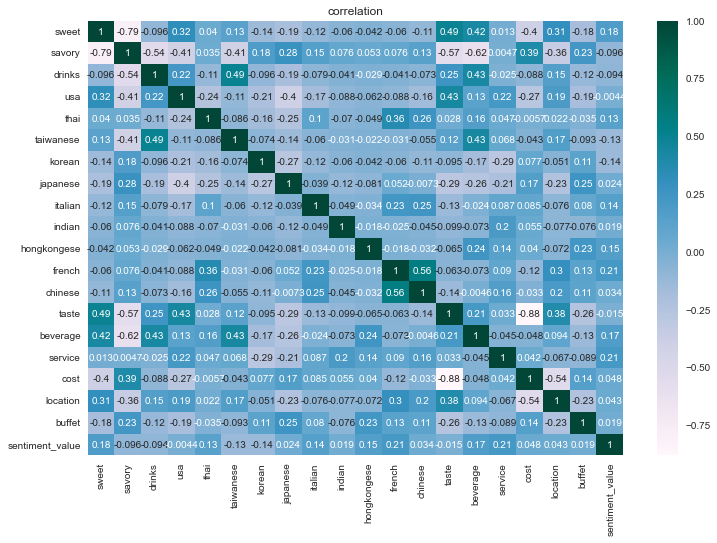

In [84]:
plt.figure(figsize = (12,8))
sns.heatmap(x_train.corr(), annot = True, cmap = 'PuBuGn')
plt.title("correlation")

In [85]:
# inspect if any x columns have high correlation with other columns using VIF – variance inflaction factor

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
print(vif)

           Features         VIF
1            savory  4584511.06
0             sweet   695034.08
2            drinks   347903.41
13            taste       12.06
16             cost       10.93
7          japanese        6.42
3               usa        6.25
4              thai        4.76
6            korean        4.07
11           french        3.12
14         beverage        2.91
5         taiwanese        2.90
17         location        2.43
12          chinese        2.01
10      hongkongese        1.86
15          service        1.71
8           italian        1.68
9            indian        1.63
18           buffet        1.47
19  sentiment_value        1.41


In [86]:
# drop the columns that show significantly high VIF values

x_train.drop(['savory', 'sweet', 'drinks'], axis = 1, inplace = True)
x_train.head()

,usa,thai,taiwanese,korean,japanese,italian,indian,hongkongese,french,chinese,taste,beverage,service,cost,location,buffet,sentiment_value
77,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049935,1.0,0.0,0.998703,0.009987,0.0,1.0
19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024991,0.0,1.0,0.999638,0.009996,0.0,-1.0
115,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014998,0.0,1.0,0.999872,0.005499,0.0,1.0
27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013332,1.0,0.0,0.999886,0.007110,0.0,-1.0
36,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026636,0.0,0.0,0.998846,0.039954,0.0,0.0


In [87]:
x_test.drop(['savory', 'sweet', 'drinks'], axis = 1, inplace = True)
x_test.head()

,usa,thai,taiwanese,korean,japanese,italian,indian,hongkongese,french,chinese,taste,beverage,service,cost,location,buffet,sentiment_value
95,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013332,0.0,-1.0,0.999903,0.004000,0.0,-1.0
44,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012657,1.0,0.0,0.999905,0.005379,0.0,1.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.030738,1.0,0.0,0.998981,0.033043,0.0,-1.0
97,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.007792,1.0,0.0,0.999959,0.004675,0.0,1.0
69,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.024984,1.0,-1.0,0.999376,0.024984,0.0,0.0


Modeling

In [88]:
# create logistic regression model

logr = LogisticRegression()

In [89]:
logr.fit(x_train, y_train)

LogisticRegression()

In [90]:
y_pred = logr.predict(x_test)

In [91]:
logr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Classifier Report : 
               precision    recall  f1-score   support

 unsatisfied       0.88      0.94      0.91        16
   satisfied       0.94      0.89      0.92        19

    accuracy                           0.91        35
   macro avg       0.91      0.92      0.91        35
weighted avg       0.92      0.91      0.91        35
 

Accuracy on train :  0.901 

Accuracy on test :  0.914 



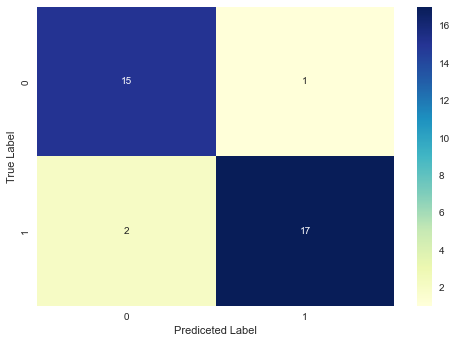

In [92]:
from sklearn import metrics

print("Classifier Report : \n", metrics.classification_report(y_test, y_pred, target_names = ['unsatisfied','satisfied']),'\n')
print("Accuracy on train : ", logr.score(x_train, y_train).round(3), '\n')
print("Accuracy on test : ", logr.score(x_test, y_test).round(3), '\n')
cf = metrics.confusion_matrix(y_test, y_pred).round(3)
sns.heatmap(cf, annot = True, cmap = 'YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Prediceted Label")
plt.show()

In [93]:
logr.intercept_

array([-0.4711436])

In [94]:
logr.coef_

array([[ 4.55548435e-01, -1.25417137e-01,  2.17717480e-01,
         3.87844231e-01,  1.22442372e-01, -5.83640703e-02,
        -7.12564918e-02,  5.80890908e-02,  3.06410067e-01,
        -6.30537866e-01,  1.94598262e-02, -1.20947993e-01,
         9.16368702e-01,  8.45355508e-04, -1.85512205e-02,
         2.62374336e-01,  2.14062749e+00]])

In [95]:
np.exp(logr.coef_)

array([[1.57703805, 0.88212886, 1.24323578, 1.47380019, 1.13025398,
        0.94330646, 0.93122301, 1.05980941, 1.35853928, 0.53230541,
        1.0196504 , 0.88608004, 2.50019493, 1.00084571, 0.98161979,
        1.30001309, 8.50477261]])

In [96]:
# determine the coefficient of each x column which shows the importance of each column on the prediction

x_coef = pd.DataFrame()
x_coef['x'] = x_train.columns 
x_coef['coefficient'] = np.reshape(np.exp(logr.coef_), (17,1))
x_coef

,x,coefficient
0,usa,1.577038
1,thai,0.882129
2,taiwanese,1.243236
3,korean,1.473800
4,japanese,1.130254
5,italian,0.943306
6,indian,0.931223
7,hongkongese,1.059809
8,french,1.358539
9,chinese,0.532305


In [97]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(x_coef.columns),
                fill_color='#0C84A1',
                line_color = '#0C84A1',
                align='center',
                font=dict(color='white', size=12)),
    cells=dict(values=[x_coef.x, x_coef.coefficient],
               fill_color='white',
               line_color = '#0C84A1',
               align='left'), domain=dict(x=[0,0.4]))
])

fig.show()

In [98]:
pred_prob = logr.predict_proba(x_test)
pred_prob

array([[0.95848364, 0.04151636],
       [0.19401799, 0.80598201],
       [0.91874971, 0.08125029],
       [0.15817256, 0.84182744],
       [0.67822668, 0.32177332],
       [0.10656585, 0.89343415],
       [0.78702536, 0.21297464],
       [0.131398  , 0.868602  ],
       [0.09261237, 0.90738763],
       [0.90230155, 0.09769845],
       [0.89617841, 0.10382159],
       [0.08393538, 0.91606462],
       [0.11352666, 0.88647334],
       [0.89614193, 0.10385807],
       [0.96785641, 0.03214359],
       [0.05110355, 0.94889645],
       [0.17590348, 0.82409652],
       [0.06244279, 0.93755721],
       [0.75011433, 0.24988567],
       [0.96784946, 0.03215054],
       [0.15319541, 0.84680459],
       [0.45016022, 0.54983978],
       [0.0377973 , 0.9622027 ],
       [0.05110962, 0.94889038],
       [0.95861118, 0.04138882],
       [0.04858226, 0.95141774],
       [0.87433542, 0.12566458],
       [0.90229832, 0.09770168],
       [0.52055386, 0.47944614],
       [0.04872448, 0.95127552],
       [0.

In [99]:
metrics.roc_auc_score(y_test, pred_prob[:,1])

0.9375

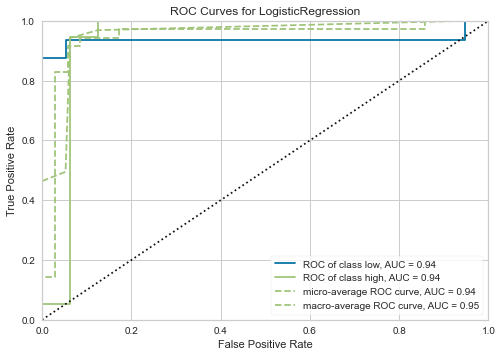

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [100]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(logr, classes = ['low','high'])
visualizer.fit(x_train, y_train) # fit the training data into visualizer
visualizer.score(x_test, y_test) # evaluate the model on the test data
visualizer.show()

# Restaurant Satisfaction Testing

evaluating predicted results using new set of data

In [101]:
df_test = pd.DataFrame(pd.read_excel('Restaurant Data.xlsx', sheet_name = "DataTest"))
df_test.head(5)

,restaurant,type,cuisine,taste,beverage,service,cost,location,buffet,opinion,sentiment,satisfied
0,Tonkatsu Wako,savory,japanese,4.0,0.0,0.0,370.0,1.5,0.0,looks nice pretty expensive but interesting,NaN,NaN
1,Koi tea,drinks,taiwanese,3.0,1.0,1.0,80.0,2.0,0.0,great drinks for drinking in special occasion,NaN,NaN
2,Gaga,drinks,taiwanese,3.0,1.0,0.0,90.0,2.0,0.0,interesting drinks choice with great lemon tea,NaN,NaN
3,Drop by Dough,sweet,usa,3.0,1.0,0.0,200.0,14.6,0.0,very sweet donut filled with a lot of fillings,NaN,NaN
4,Baan Ying,savory,thai,4.0,0.0,1.0,200.0,2.0,0.0,nice authentic thai food with lot of choices t...,NaN,NaN


Sentiment Prediction

In [102]:
opinion_test_df = pd.DataFrame(df_test['opinion'])
opinion_test_df

,opinion
0,looks nice pretty expensive but interesting
1,great drinks for drinking in special occasion
2,interesting drinks choice with great lemon tea
3,very sweet donut filled with a lot of fillings
4,nice authentic thai food with lot of choices t...
5,cheap thai noodle place with fast service but ...
6,not that fresh ingredients but various choice ...
7,cheap thai noodle in the middle of siam
8,not very nice service but the food is fine
9,have to wait very long but great and refreshin...


In [103]:
# encode opinion into numerical data

opinion_test_df['opinion'] = opinion_test_df['opinion'].apply(lambda x: ' '.join(text_cleaning(x)))
opinion_test = opinion_test_df['opinion'].tolist()
encoded_phrases_test = [one_hot(d, vocab_size) for d in opinion_test] # encode words into numbers
opinion_test_df['opinion'] = encoded_phrases_test
opinion_test_df['opinion']

0                    [3436, 13252, 19148, 1507, 12393]
1                   [13999, 17391, 3409, 12978, 10519]
2            [12393, 17391, 8231, 13999, 19729, 15118]
3                    [9787, 5931, 17107, 11500, 19053]
4       [13252, 4920, 11056, 6636, 11500, 8231, 11842]
5    [12257, 11056, 19076, 16255, 18239, 12959, 427...
6              [2803, 16526, 2636, 8231, 11056, 15547]
7                    [12257, 11056, 19076, 2558, 5057]
8                          [13252, 12959, 6636, 15667]
9                   [17440, 17423, 13999, 19249, 2038]
Name: opinion, dtype: object

In [104]:
opinion_test_text = keras.preprocessing.sequence.pad_sequences(opinion_test_df['opinion'], maxlen = maxlen)
opinion_test_text

array([[    0,     0,     0, ..., 19148,  1507, 12393],
       [    0,     0,     0, ...,  3409, 12978, 10519],
       [    0,     0,     0, ..., 13999, 19729, 15118],
       ...,
       [    0,     0,     0, ..., 19076,  2558,  5057],
       [    0,     0,     0, ..., 12959,  6636, 15667],
       [    0,     0,     0, ..., 13999, 19249,  2038]], dtype=int32)

In [105]:
# predict sentiment from the model

y_test_pred = textmodel.predict(opinion_test_text)
y_test_pred

array([[0.8413247 , 0.68831444, 0.268187  ],
       [0.19382322, 0.5213211 , 0.68733454],
       [0.17278817, 0.32403362, 0.8462725 ],
       [0.8904828 , 0.638394  , 0.26267862],
       [0.38494655, 0.7526866 , 0.36679012],
       [0.702285  , 0.7828131 , 0.2496461 ],
       [0.17444488, 0.30276012, 0.86177945],
       [0.62489706, 0.8244285 , 0.22333947],
       [0.42156482, 0.7973135 , 0.30146354],
       [0.23141202, 0.5957893 , 0.60388315]], dtype=float32)

In [106]:
# get predicted result by getting the largest class in y_pred

y_test_pred_max = np.argmax(y_test_pred, axis = 1, keepdims = True)
y_test_pred_max

array([[0],
       [2],
       [2],
       [0],
       [1],
       [1],
       [2],
       [1],
       [1],
       [2]])

In [107]:
opinion_test_df['sentiment'] = y_test_pred_max
opinion_test_df

,opinion,sentiment
0,"[3436, 13252, 19148, 1507, 12393]",0
1,"[13999, 17391, 3409, 12978, 10519]",2
2,"[12393, 17391, 8231, 13999, 19729, 15118]",2
3,"[9787, 5931, 17107, 11500, 19053]",0
4,"[13252, 4920, 11056, 6636, 11500, 8231, 11842]",1
5,"[12257, 11056, 19076, 16255, 18239, 12959, 427...",1
6,"[2803, 16526, 2636, 8231, 11056, 15547]",2
7,"[12257, 11056, 19076, 2558, 5057]",1
8,"[13252, 12959, 6636, 15667]",1
9,"[17440, 17423, 13999, 19249, 2038]",2


In [108]:
opinion_test_df['sentiment'].replace({0 : 'negative', 1 : 'neutral', 2 : 'positive'}, inplace = True)
opinion_test_df

,opinion,sentiment
0,"[3436, 13252, 19148, 1507, 12393]",negative
1,"[13999, 17391, 3409, 12978, 10519]",positive
2,"[12393, 17391, 8231, 13999, 19729, 15118]",positive
3,"[9787, 5931, 17107, 11500, 19053]",negative
4,"[13252, 4920, 11056, 6636, 11500, 8231, 11842]",neutral
5,"[12257, 11056, 19076, 16255, 18239, 12959, 427...",neutral
6,"[2803, 16526, 2636, 8231, 11056, 15547]",positive
7,"[12257, 11056, 19076, 2558, 5057]",neutral
8,"[13252, 12959, 6636, 15667]",neutral
9,"[17440, 17423, 13999, 19249, 2038]",positive


In [109]:
df_test['sentiment'] = opinion_test_df['sentiment']
df_test

,restaurant,type,cuisine,taste,beverage,service,cost,location,buffet,opinion,sentiment,satisfied
0,Tonkatsu Wako,savory,japanese,4.0,0.0,0.0,370.0,1.50,0.0,looks nice pretty expensive but interesting,negative,NaN
1,Koi tea,drinks,taiwanese,3.0,1.0,1.0,80.0,2.00,0.0,great drinks for drinking in special occasion,positive,NaN
2,Gaga,drinks,taiwanese,3.0,1.0,0.0,90.0,2.00,0.0,interesting drinks choice with great lemon tea,positive,NaN
3,Drop by Dough,sweet,usa,3.0,1.0,0.0,200.0,14.60,0.0,very sweet donut filled with a lot of fillings,negative,NaN
4,Baan Ying,savory,thai,4.0,0.0,1.0,200.0,2.00,0.0,nice authentic thai food with lot of choices t...,neutral,NaN
5,Boat Noodle,savory,thai,4.0,1.0,1.0,80.0,3.00,0.0,cheap thai noodle place with fast service but ...,neutral,NaN
6,Tom Toon Shabu,savory,thai,3.0,0.0,0.0,395.0,2.10,1.0,not that fresh ingredients but various choice ...,positive,NaN
7,Piranya,savory,thai,3.0,1.0,0.0,100.0,2.00,0.0,cheap thai noodle in the middle of siam,neutral,NaN
8,Hoturu119,savory,japanese,4.0,0.0,-1.0,1000.0,3.00,0.0,not very nice service but the food is fine,neutral,NaN
9,Tuay Tung,sweet,chinese,4.0,0.0,0.0,80.0,0.75,0.0,have to wait very long but great and refreshin...,positive,NaN


Satisfaction Prediction

In [110]:
cuisine_test_list = df_test['cuisine'].str.split(',').tolist()

In [111]:
cuisine_test_df = pd.DataFrame([], columns = mlb.classes_)
cuisine_test_df

,chinese,french,hongkongese,indian,italian,japanese,korean,taiwanese,thai,usa


In [112]:
mlb2 = MultiLabelBinarizer()
cuisine_test_df_mlb = pd.DataFrame(mlb2.fit_transform(cuisine_test_list), columns = mlb2.classes_)
cuisine_test_df_mlb

,chinese,japanese,taiwanese,thai,usa
0,0,1,0,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,0,1,0
5,0,0,0,1,0
6,0,0,0,1,0
7,0,0,0,1,0
8,0,1,0,0,0
9,1,0,0,0,0


In [113]:
cuisine_test_df = pd.concat([cuisine_test_df,cuisine_test_df_mlb]).fillna(0)
cuisine_test_df

,chinese,french,hongkongese,indian,italian,japanese,korean,taiwanese,thai,usa
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,1,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0


In [114]:
index = 3
for column in cuisine_test_df.columns:
    df_test.insert(loc = index, column = column, value = cuisine_test_df[column].astype(float))
    index + 1
df_test

,restaurant,type,cuisine,usa,thai,taiwanese,korean,japanese,italian,indian,...,chinese,taste,beverage,service,cost,location,buffet,opinion,sentiment,satisfied
0,Tonkatsu Wako,savory,japanese,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,4.0,0.0,0.0,370.0,1.50,0.0,looks nice pretty expensive but interesting,negative,NaN
1,Koi tea,drinks,taiwanese,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,1.0,80.0,2.00,0.0,great drinks for drinking in special occasion,positive,NaN
2,Gaga,drinks,taiwanese,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,0.0,90.0,2.00,0.0,interesting drinks choice with great lemon tea,positive,NaN
3,Drop by Dough,sweet,usa,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,0.0,200.0,14.60,0.0,very sweet donut filled with a lot of fillings,negative,NaN
4,Baan Ying,savory,thai,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,1.0,200.0,2.00,0.0,nice authentic thai food with lot of choices t...,neutral,NaN
5,Boat Noodle,savory,thai,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,1.0,1.0,80.0,3.00,0.0,cheap thai noodle place with fast service but ...,neutral,NaN
6,Tom Toon Shabu,savory,thai,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,395.0,2.10,1.0,not that fresh ingredients but various choice ...,positive,NaN
7,Piranya,savory,thai,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,0.0,100.0,2.00,0.0,cheap thai noodle in the middle of siam,neutral,NaN
8,Hoturu119,savory,japanese,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,4.0,0.0,-1.0,1000.0,3.00,0.0,not very nice service but the food is fine,neutral,NaN
9,Tuay Tung,sweet,chinese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,0.0,0.0,80.0,0.75,0.0,have to wait very long but great and refreshin...,positive,NaN


In [115]:
sentiment_test_df = pd.DataFrame()
sentiment_test_df['sentiment_value'] = df_test['sentiment'].replace({'negative' : -1, 'neutral' : 0, 'positive' : 1})
sentiment_test_df

,sentiment_value
0,-1
1,1
2,1
3,-1
4,0
5,0
6,1
7,0
8,0
9,1


In [116]:
# change all categorial data to numberical data using OneHotEncoder (type) and MultiLabelBinarizer (cuisine)

df_test.insert(loc = len(df_test.columns), column = 'sentiment_value', value = sentiment_test_df['sentiment_value'].astype(float))
df_test

,restaurant,type,cuisine,usa,thai,taiwanese,korean,japanese,italian,indian,...,taste,beverage,service,cost,location,buffet,opinion,sentiment,satisfied,sentiment_value
0,Tonkatsu Wako,savory,japanese,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4.0,0.0,0.0,370.0,1.50,0.0,looks nice pretty expensive but interesting,negative,NaN,-1.0
1,Koi tea,drinks,taiwanese,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,1.0,1.0,80.0,2.00,0.0,great drinks for drinking in special occasion,positive,NaN,1.0
2,Gaga,drinks,taiwanese,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,90.0,2.00,0.0,interesting drinks choice with great lemon tea,positive,NaN,1.0
3,Drop by Dough,sweet,usa,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,200.0,14.60,0.0,very sweet donut filled with a lot of fillings,negative,NaN,-1.0
4,Baan Ying,savory,thai,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,1.0,200.0,2.00,0.0,nice authentic thai food with lot of choices t...,neutral,NaN,0.0
5,Boat Noodle,savory,thai,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,1.0,80.0,3.00,0.0,cheap thai noodle place with fast service but ...,neutral,NaN,0.0
6,Tom Toon Shabu,savory,thai,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,395.0,2.10,1.0,not that fresh ingredients but various choice ...,positive,NaN,1.0
7,Piranya,savory,thai,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,100.0,2.00,0.0,cheap thai noodle in the middle of siam,neutral,NaN,0.0
8,Hoturu119,savory,japanese,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4.0,0.0,-1.0,1000.0,3.00,0.0,not very nice service but the food is fine,neutral,NaN,0.0
9,Tuay Tung,sweet,chinese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,80.0,0.75,0.0,have to wait very long but great and refreshin...,positive,NaN,1.0


In [117]:
df_test.drop(['restaurant','type','cuisine','opinion','sentiment', 'satisfied'], axis = 1, inplace = True)

In [118]:
df_test.dtypes

usa                float64
thai               float64
taiwanese          float64
korean             float64
japanese           float64
italian            float64
indian             float64
hongkongese        float64
french             float64
chinese            float64
taste              float64
beverage           float64
service            float64
cost               float64
location           float64
buffet             float64
sentiment_value    float64
dtype: object

In [119]:
df_test

,usa,thai,taiwanese,korean,japanese,italian,indian,hongkongese,french,chinese,taste,beverage,service,cost,location,buffet,sentiment_value
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,370.0,1.50,0.0,-1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,80.0,2.00,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,90.0,2.00,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,200.0,14.60,0.0,-1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,200.0,2.00,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,80.0,3.00,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,395.0,2.10,1.0,1.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,100.0,2.00,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,-1.0,1000.0,3.00,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,80.0,0.75,0.0,1.0


In [120]:
test_normalize = pd.DataFrame()
test_normalize['taste'] = df_test['taste']
test_normalize['cost'] = df_test['cost']
test_normalize['location'] = df_test['location']
test_normalize

,taste,cost,location
0,4.0,370.0,1.50
1,3.0,80.0,2.00
2,3.0,90.0,2.00
3,3.0,200.0,14.60
4,4.0,200.0,2.00
5,4.0,80.0,3.00
6,3.0,395.0,2.10
7,3.0,100.0,2.00
8,4.0,1000.0,3.00
9,4.0,80.0,0.75


In [121]:
test_normalize = pd.DataFrame(normalizer.transform(test_normalize), columns = ['taste', 'cost', 'location'])
test_normalize

,taste,cost,location
0,0.010810,0.999933,0.004054
1,0.037462,0.998986,0.024975
2,0.033307,0.999198,0.022204
3,0.014959,0.997235,0.072798
4,0.019995,0.999750,0.009998
5,0.049903,0.998053,0.037427
6,0.007595,0.999957,0.005316
7,0.029981,0.999351,0.019987
8,0.004000,0.999988,0.003000
9,0.049935,0.998709,0.009363


In [122]:
# add the normalized columns back to the DataFrame

for column in test_normalize.columns:
    df_test[column] = test_normalize[column].values
df_test

,usa,thai,taiwanese,korean,japanese,italian,indian,hongkongese,french,chinese,taste,beverage,service,cost,location,buffet,sentiment_value
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.010810,0.0,0.0,0.999933,0.004054,0.0,-1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037462,1.0,1.0,0.998986,0.024975,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033307,1.0,0.0,0.999198,0.022204,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014959,1.0,0.0,0.997235,0.072798,0.0,-1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019995,0.0,1.0,0.999750,0.009998,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049903,1.0,1.0,0.998053,0.037427,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007595,0.0,0.0,0.999957,0.005316,1.0,1.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029981,1.0,0.0,0.999351,0.019987,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.004000,0.0,-1.0,0.999988,0.003000,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.049935,0.0,0.0,0.998709,0.009363,0.0,1.0


In [123]:
test_pred_prob = logr.predict_proba(df_test)
test_pred_prob

array([[0.92332094, 0.07667906],
       [0.06394013, 0.93605987],
       [0.14587415, 0.85412585],
       [0.90698685, 0.09301315],
       [0.42046697, 0.57953303],
       [0.45017084, 0.54982916],
       [0.14096045, 0.85903955],
       [0.67182509, 0.32817491],
       [0.77974868, 0.22025132],
       [0.26103649, 0.73896351]])

In [124]:
# get predicted result by getting the largest class in test_pred_prob

test_pred_prob_max = np.argmax(test_pred_prob, axis = 1, keepdims = True)
test_pred_prob_max

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1]])

In [125]:
df_test['satisfied'] = test_pred_prob_max
df_test

,usa,thai,taiwanese,korean,japanese,italian,indian,hongkongese,french,chinese,taste,beverage,service,cost,location,buffet,sentiment_value,satisfied
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.010810,0.0,0.0,0.999933,0.004054,0.0,-1.0,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037462,1.0,1.0,0.998986,0.024975,0.0,1.0,1
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033307,1.0,0.0,0.999198,0.022204,0.0,1.0,1
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014959,1.0,0.0,0.997235,0.072798,0.0,-1.0,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019995,0.0,1.0,0.999750,0.009998,0.0,0.0,1
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049903,1.0,1.0,0.998053,0.037427,0.0,0.0,1
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007595,0.0,0.0,0.999957,0.005316,1.0,1.0,1
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029981,1.0,0.0,0.999351,0.019987,0.0,0.0,0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.004000,0.0,-1.0,0.999988,0.003000,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.049935,0.0,0.0,0.998709,0.009363,0.0,1.0,1


Prediction Result

In [126]:
result_df = pd.DataFrame(pd.read_excel('Restaurant Data.xlsx', sheet_name = "DataTest"))
result_df.head(5)

,restaurant,type,cuisine,taste,beverage,service,cost,location,buffet,opinion,sentiment,satisfied
0,Tonkatsu Wako,savory,japanese,4.0,0.0,0.0,370.0,1.5,0.0,looks nice pretty expensive but interesting,NaN,NaN
1,Koi tea,drinks,taiwanese,3.0,1.0,1.0,80.0,2.0,0.0,great drinks for drinking in special occasion,NaN,NaN
2,Gaga,drinks,taiwanese,3.0,1.0,0.0,90.0,2.0,0.0,interesting drinks choice with great lemon tea,NaN,NaN
3,Drop by Dough,sweet,usa,3.0,1.0,0.0,200.0,14.6,0.0,very sweet donut filled with a lot of fillings,NaN,NaN
4,Baan Ying,savory,thai,4.0,0.0,1.0,200.0,2.0,0.0,nice authentic thai food with lot of choices t...,NaN,NaN


In [127]:
# get results from both predictions

result_df['sentiment'] = opinion_test_df['sentiment']
result_df['satisfied'] = df_test['satisfied']
result_df

,restaurant,type,cuisine,taste,beverage,service,cost,location,buffet,opinion,sentiment,satisfied
0,Tonkatsu Wako,savory,japanese,4.0,0.0,0.0,370.0,1.50,0.0,looks nice pretty expensive but interesting,negative,0
1,Koi tea,drinks,taiwanese,3.0,1.0,1.0,80.0,2.00,0.0,great drinks for drinking in special occasion,positive,1
2,Gaga,drinks,taiwanese,3.0,1.0,0.0,90.0,2.00,0.0,interesting drinks choice with great lemon tea,positive,1
3,Drop by Dough,sweet,usa,3.0,1.0,0.0,200.0,14.60,0.0,very sweet donut filled with a lot of fillings,negative,0
4,Baan Ying,savory,thai,4.0,0.0,1.0,200.0,2.00,0.0,nice authentic thai food with lot of choices t...,neutral,1
5,Boat Noodle,savory,thai,4.0,1.0,1.0,80.0,3.00,0.0,cheap thai noodle place with fast service but ...,neutral,1
6,Tom Toon Shabu,savory,thai,3.0,0.0,0.0,395.0,2.10,1.0,not that fresh ingredients but various choice ...,positive,1
7,Piranya,savory,thai,3.0,1.0,0.0,100.0,2.00,0.0,cheap thai noodle in the middle of siam,neutral,0
8,Hoturu119,savory,japanese,4.0,0.0,-1.0,1000.0,3.00,0.0,not very nice service but the food is fine,neutral,0
9,Tuay Tung,sweet,chinese,4.0,0.0,0.0,80.0,0.75,0.0,have to wait very long but great and refreshin...,positive,1
